In [2]:
import torch
import torch.nn as nn
import torch.utils
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [4]:
class FF(nn.Module):
    def __init__(self, dim1, dim2, dim3):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(in_features=dim1, out_features=dim2),
            nn.ReLU(),
            nn.Linear(in_features=dim2, out_features=dim3)
        )

    def forward(self, input):
        return self.main(input)

In [5]:
class VAE(nn.Module):
    def __init__(self, dim1, dim2, dim3):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(dim1, dim2)
        self.fc21 = nn.Linear(dim2, dim3)  # Mean
        self.fc22 = nn.Linear(dim2, dim3)  # Variance
        self.fc3 = nn.Linear(dim3, dim2)
        self.fc4 = nn.Linear(dim2, dim1)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [6]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [7]:
def train(data_loader, model, optimizer, epochs=20):
    model.to(device)  # GPU
    model.train()
    losses = []
    for epoch in range(epochs):
        for i, (x, _) in enumerate(data_loader):
            x = x.to(device)  # GPU
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(x)
            loss = loss_function(recon_batch, x, mu, logvar)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print(f"{epoch}/{i}: {loss.item()}")
    return model, losses

In [8]:
def plot_latent(data_loader, model, num_batches=100):
    model.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(data_loader):
            x = x.to(device)
            mu, logvar = model.encode(x.view(-1, 28*28))
            z = model.reparameterize(mu, logvar)
            z = z.to('cpu').detach().numpy()
            plt.scatter(z[:, 0], z[:, 1], c=y, alpha=0.5)
            if i > num_batches:
                plt.colorbar()
                break

In [9]:
def plot_vae_reconstructed(decoder, w, h, latent_dim, r0=(-10, 10), r1=(-10, 10), n=12):
    img = np.zeros((n*w, n*h))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            # Sampling z from the standard normal distribution for each dimension
            z = torch.randn(1, latent_dim).to(device)  # Use the dynamic dimension
            x_hat = decoder(z)
            x_hat = x_hat.reshape(w, h).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])


In [10]:
# Load MNIST dataset
transform_vae = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x, start_dim=-2))
])

data_vae = datasets.MNIST('./data', transform=transform_vae, download=True)

n, w, h = data_vae.data.shape

data_loader_vae = torch.utils.data.DataLoader(data_vae, batch_size=128, shuffle=True)

# Initialize VAE model
vae_model = VAE(dim1=28*28, dim2=512, dim3=2)

# Initialize optimizer
optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-3)

# Train VAE model
trained_model, losses = train(data_loader_vae, vae_model, optimizer)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:09<00:00, 1084653.90it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 156244.45it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1516818.48it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1336504.05it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

0/0: 70823.1015625
0/100: 24150.111328125
0/200: 23261.51953125
0/300: 22493.185546875
0/400: 21538.7265625
1/0: 21223.650390625
1/100: 20859.8671875
1/200: 20837.373046875
1/300: 21820.7578125
1/400: 21087.3984375
2/0: 20884.578125
2/100: 20547.68359375
2/200: 20777.796875
2/300: 21066.705078125
2/400: 20640.826171875
3/0: 21149.392578125
3/100: 19404.765625
3/200: 21000.505859375
3/300: 20867.720703125
3/400: 20298.033203125
4/0: 21194.1953125
4/100: 20215.736328125
4/200: 18866.94140625
4/300: 19036.48046875
4/400: 19750.62109375
5/0: 20620.455078125
5/100: 20943.01171875
5/200: 20540.546875
5/300: 19664.609375
5/400: 20746.3828125
6/0: 19795.533203125
6/100: 20445.365234375
6/200: 20078.25390625
6/300: 19420.716796875
6/400: 20177.84375
7/0: 20391.171875
7/100: 19386.75390625
7/200: 19601.330078125
7/300: 20157.91015625
7/400: 20062.09765625
8/0: 19366.6015625
8/100: 19469.74609375
8/200: 19540.9296875
8/300

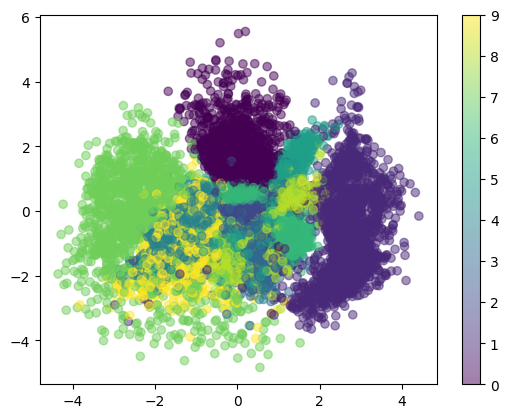

In [11]:
# Plot latent space
plot_latent(data_loader_vae, trained_model)
plt.show()

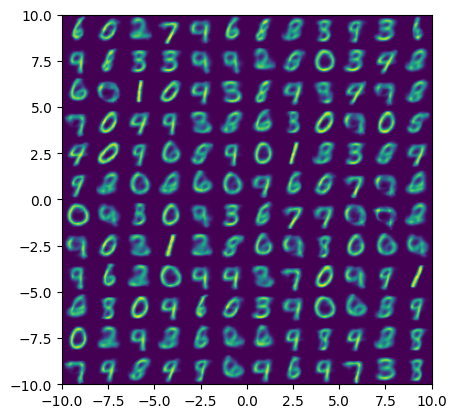

In [12]:
# plot_vae_reconstructed(trained_model.decode, w, h)
latent_dim = trained_model.fc21.out_features  # Dynamically get the latent dimension
plot_vae_reconstructed(trained_model.decode, w, h, latent_dim)
plt.show()

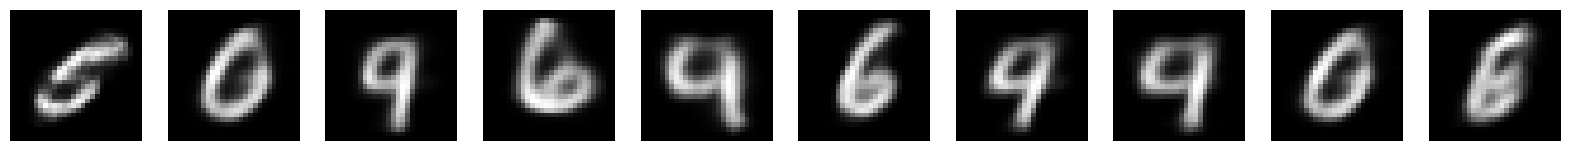

<Figure size 640x480 with 0 Axes>

In [27]:
def plot_generated_samples(model, num_samples=10):
    with torch.no_grad():
        z = torch.randn(num_samples, model.fc21.out_features).to(device)  # Sample from standard normal distribution
        generated_samples = model.decode(z).cpu().view(-1, 1, 28, 28)  # Pass through decoder
        generated_samples = generated_samples.numpy()

        fig, axs = plt.subplots(1, num_samples, figsize=(20, 2))
        for i, sample in enumerate(generated_samples):
            axs[i].imshow(sample[0], cmap='gray')
            axs[i].axis('off')
        plt.show()

# Plot generated samples
plot_generated_samples(trained_model)
plt.savefig('generated.pdf')